                                        Trader Performance vs Market Sentiment


In [1]:
# Import required libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display all columns without truncation
pd.set_option("display.max_columns", None)


                                                     Datasets


In [2]:
# Load the Fear & Greed sentiment dataset
sentiment = pd.read_csv("../data/fear_greed_index.csv")

# Load historical trader execution data
trades = pd.read_csv("../data/historical_data.csv")

# Preview both datasets
sentiment.head(), trades.head()


(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY 

                                                Data Preparation


In [ ]:
# Standardize column names to lowercase to avoid KeyError issues
sentiment.columns = sentiment.columns.str.strip().str.lower()
trades.columns = trades.columns.str.strip().str.lower()

# Convert sentiment date column to datetime 
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Convert trade timestamps  to datetime
trades['time'] = pd.to_datetime(trades['timestamp'], unit='ms')

# Extract trade date for alignment with sentiment data
trades['date'] = trades['time'].dt.date


In [4]:
# Merge trade data with daily market sentiment
# Each trade is associated with the sentiment of the day it was executed
df = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

# Validate merge result
df[['date', 'classification']].head()


,date,classification
0,2024-10-27,Greed
1,2024-10-27,Greed
2,2024-10-27,Greed
3,2024-10-27,Greed
4,2024-10-27,Greed


In [5]:
# Identify whether the trade is a long position
df['is_long'] = df['side'].str.lower().eq('buy')

# Identify whether the trade was profitable
df['is_win'] = df['closed pnl'] > 0

# Compute absolute trade size in USD
df['abs_size_usd'] = df['size usd'].abs()


                                                 Feature Engineering


In [6]:
# Aggregate trades at a daily account level to analyze behavior and performance
daily = (
    df.groupby(['account', 'date', 'classification'])
      .agg(
          daily_pnl=('closed pnl', 'sum'),            # Total PnL per day
          win_rate=('is_win', 'mean'),                # Percentage of winning trades
          avg_trade_size_usd=('abs_size_usd', 'mean'),# Average trade size
          trades_per_day=('closed pnl', 'count'),     # Trading frequency
          long_ratio=('is_long', 'mean')              # Long vs short bias
      )
      .reset_index()
)

# Preview aggregated metrics
daily.head()


,account,date,classification,daily_pnl,win_rate,avg_trade_size_usd,trades_per_day,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,Greed,-3.275059e+05,0.025974,14810.891818,462,0.300866
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,Fear,1.927736e+06,0.405542,16345.241940,3356,0.468415
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,Greed,2.060745e+04,0.531250,2492.749906,320,0.453125
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,Fear,1.709873e+04,0.435041,1693.351684,3533,0.432494
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,Neutral,-1.000000e+00,0.000000,6070.200000,5,0.400000


                                         Performance Analysis: Fear vs Greed


In [7]:
# Focus analysis on extreme sentiment regimes only
analysis_df = daily[daily['classification'].isin(['Fear', 'Greed'])].copy()

# Check distribution of sentiment classes
analysis_df['classification'].value_counts()


classification
Greed    32
Fear     32
Name: count, dtype: int64

                                                Daily Trader Metrics


In [8]:
# Compare average performance metrics across sentiment regimes
perf_summary = (
    analysis_df
    .groupby('classification')[['daily_pnl', 'win_rate']]
    .mean()
    .reset_index()
)

perf_summary


,classification,daily_pnl,win_rate
0,Fear,209372.662205,0.415878
1,Greed,99675.516731,0.374074


                                                     Key Insights


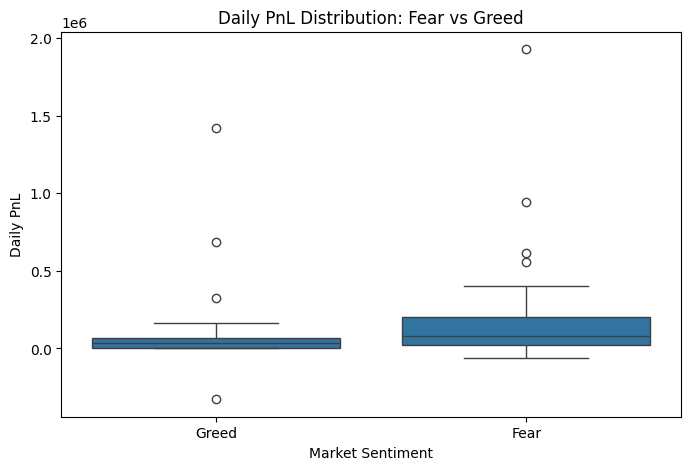

In [ ]:
# Visualize distribution of daily PnL across sentiment regimes
# Boxplot highlights volatility differences between Fear and Greed

plt.figure(figsize=(8,5))
sns.boxplot(
    data=analysis_df,
    x='classification',
    y='daily_pnl'
)
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.show()


In [20]:
perf_summary.to_csv("../outputs/tables/performance_summary.csv", index=False)


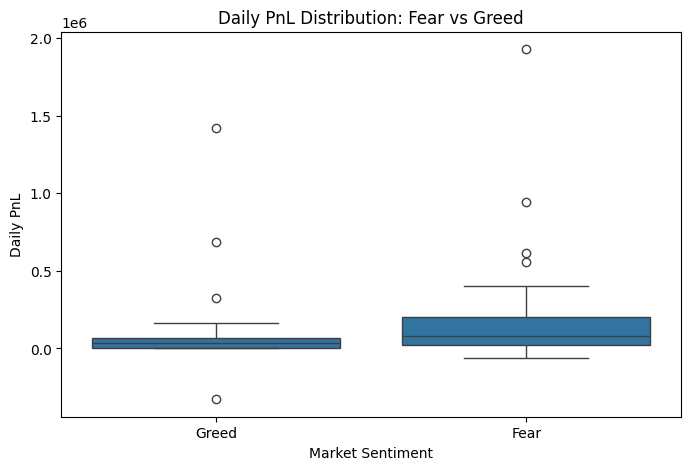

In [16]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=analysis_df,
    x='classification',
    y='daily_pnl'
)
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.ylabel("Daily PnL")
plt.xlabel("Market Sentiment")
plt.show()


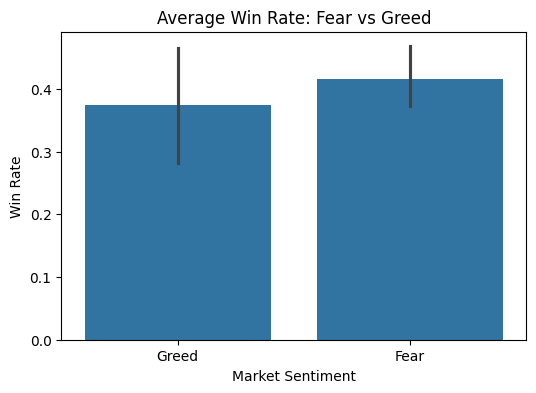

In [17]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=analysis_df,
    x='classification',
    y='win_rate',
    estimator=np.mean
)
plt.title("Average Win Rate: Fear vs Greed")
plt.ylabel("Win Rate")
plt.xlabel("Market Sentiment")
plt.show()


In [18]:
behavior_summary = (
    analysis_df
    .groupby('classification')[[
        'trades_per_day',
        'avg_trade_size_usd',
        'long_ratio'
    ]]
    .mean()
    .reset_index()
)

behavior_summary


,classification,trades_per_day,avg_trade_size_usd,long_ratio
0,Fear,4183.46875,5926.522723,0.459352
1,Greed,1134.03125,5839.310974,0.495780


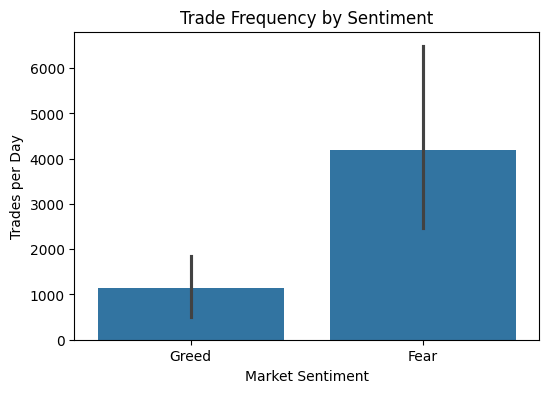

In [19]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=analysis_df,
    x='classification',
    y='trades_per_day'
)
plt.title("Trade Frequency by Sentiment")
plt.ylabel("Trades per Day")
plt.xlabel("Market Sentiment")
plt.show()


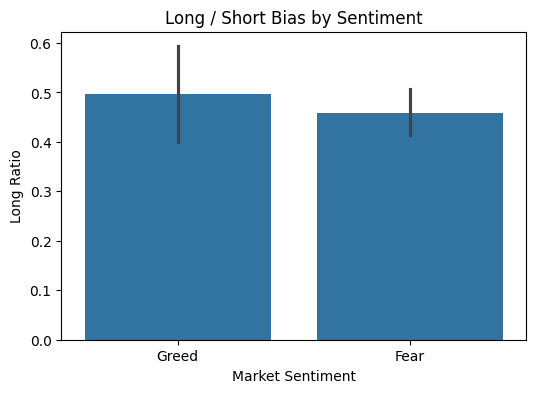

In [20]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=analysis_df,
    x='classification',
    y='long_ratio'
)
plt.title("Long / Short Bias by Sentiment")
plt.ylabel("Long Ratio")
plt.xlabel("Market Sentiment")
plt.show()


In [27]:
analysis_df['frequency_segment'] = pd.qcut(
    analysis_df['trades_per_day'],
    q=2,
    labels=['Infrequent', 'Frequent']
)
freq_perf = (
    analysis_df
    .groupby(['frequency_segment', 'classification'])['daily_pnl']
    .mean()
    .reset_index()
)

freq_perf


,frequency_segment,classification,daily_pnl
0,Infrequent,Fear,48402.303137
1,Infrequent,Greed,28452.671557
2,Frequent,Fear,272361.063580
3,Frequent,Greed,281689.454396


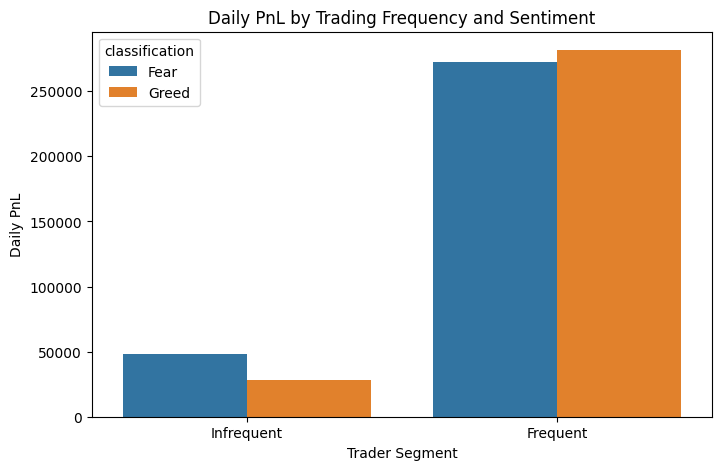

In [28]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=freq_perf,
    x='frequency_segment',
    y='daily_pnl',
    hue='classification'
)
plt.title("Daily PnL by Trading Frequency and Sentiment")
plt.ylabel("Daily PnL")
plt.xlabel("Trader Segment")
plt.show()


In [29]:
fear_df = analysis_df[analysis_df['classification'] == 'Fear']

fear_overtrade = (
    fear_df
    .groupby('frequency_segment')[['daily_pnl', 'win_rate', 'trades_per_day']]
    .mean()
    .reset_index()
)

fear_overtrade


,frequency_segment,daily_pnl,win_rate,trades_per_day
0,Infrequent,48402.303137,0.415260,413.888889
1,Frequent,272361.063580,0.416121,5658.521739


In [30]:
greed_df = analysis_df[analysis_df['classification'] == 'Greed']

greed_size_impact = (
    greed_df
    .assign(size_bucket=pd.qcut(
        greed_df['avg_trade_size_usd'], 
        q=2, 
        labels=['Smaller Size', 'Larger Size']
    ))
    .groupby('size_bucket')[['daily_pnl']]
    .mean()
    .reset_index()
)

greed_size_impact


,size_bucket,daily_pnl
0,Smaller Size,168916.483701
1,Larger Size,30434.549760


In [31]:
def trading_rule(row):
    if row['classification'] == 'Fear' and row['frequency_segment'] == 'Frequent':
        return "Reduce trade frequency"
    elif row['classification'] == 'Greed' and row['avg_trade_size_usd'] > analysis_df['avg_trade_size_usd'].median():
        return "Reduce position size"
    else:
        return "No action"

analysis_df['strategy_signal'] = analysis_df.apply(trading_rule, axis=1)

analysis_df[['account','date','classification','strategy_signal']].head()


,account,date,classification,strategy_signal
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,Greed,Reduce position size
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,Fear,Reduce trade frequency
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,Greed,No action
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,Fear,Reduce trade frequency
5,0x271b280974205ca63b716753467d5a371de622ab,2024-10-27,Greed,Reduce position size


In [32]:
analysis_df['strategy_signal'].value_counts()


strategy_signal
No action                 27
Reduce trade frequency    23
Reduce position size      14
Name: count, dtype: int64